**Create Your Own Cognitive Portrait**

**Technique: And we will all become dragons**

Here I will use fractal named "Harter-Heighway dragon". Main idea is to possess reference points on vertices of fractal.

In [1]:
import sys
import glob
import os

import cv2
import matplotlib.pyplot as plt

import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials

import numpy as np
import math

import pylab
import matplotlib

Some settings for the algorithm. Use them to make your own dragon cognitive portrait!

In [2]:
key = '__YOUR_KEY_HERE__'
endpoint = 'https://westcentralus.api.cognitive.microsoft.com'

Here specify filepath to image.

In [3]:
face = 'images/gates/gates_45.jpg'

'left' and 'right' are names of reference points to possessed on fractal.
'third' is just another point, used for affine transformation.

In [4]:
left = "pupil_left"
right = "pupil_right"
third = "nose_tip"

'depth' parameter specifies a number of iterations of the fractal.
'coef' parameter used to scale merged images.

In [5]:
depth = 5
coef = 1.4

In [6]:
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

In [7]:
with open(face, 'rb') as data:
    res = cli.face.detect_with_stream(data, return_face_landmarks=True)

img = cv2.imread(face)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
size = img.shape[0]

In [8]:
def get_two_dragon_curves(p1, p2, depth):
    if depth == 0:
        return [(p1[0], p1[1], 1)] + [(p2[0], p2[1], 1)]

    def dragon_inner(p1, p2, target_depth, depth=1):
        if depth == target_depth:
            return []

        xs = (p1[0] + p2[0]) / 2 + (p2[1] - p1[1]) / 2
        ys = (p1[1] + p2[1]) / 2 - (p2[0] - p1[0]) / 2

        return dragon_inner(p1, (xs, ys), target_depth, depth + 1) +\
                [[xs, ys, depth]] +\
                dragon_inner(p2, (xs, ys), target_depth, depth + 1)[::-1]

    return [[p1[0], p1[1], depth]] +\
            dragon_inner(p1, p2, depth) +\
            [[p2[0], p2[1], depth]] +\
            dragon_inner(p2, p1, depth) +\
            [[p1[0], p1[1], depth]]

In [9]:
pl = [res[0].face_landmarks.as_dict()[left]['x'], res[0].face_landmarks.as_dict()[left]['y']]
pr = [res[0].face_landmarks.as_dict()[right]['x'], res[0].face_landmarks.as_dict()[right]['y']]
pc = [res[0].face_landmarks.as_dict()[third]['x'], res[0].face_landmarks.as_dict()[third]['y']]

center_shift = [size / 2 - (pl[0] + pr[0]) / 2, size / 2 - (pl[1] + pr[1]) / 2]

pl[0] += center_shift[0]; pl[1] += center_shift[1]
pr[0] += center_shift[0]; pr[1] += center_shift[1]
pc[0] += center_shift[0]; pc[1] += center_shift[1]

r_shift = math.sqrt((pc[0] - pr[0]) ** 2 + (pc[1] - pr[1]) ** 2)
phi_shift = math.pi / 2 + math.atan2(pr[1] - pl[1], pr[0] - pl[0])

eyes_curve = get_two_dragon_curves(pr, pl, depth)

In [10]:
def scale(p1, p2, p3, size, coef):
    for i in range(len(p1)):
        p1[i][0] = (p1[i][0] - size / 2) * coef + size / 2
        p1[i][1] = (p1[i][1] - size / 2) * coef + size / 2
        p2[i][0] = (p2[i][0] - size / 2) * coef + size / 2
        p2[i][1] = (p2[i][1] - size / 2) * coef + size / 2
        p3[i][0] = (p3[i][0] - size / 2) * coef + size / 2
        p3[i][1] = (p3[i][1] - size / 2) * coef + size / 2
    return p1, p2, p3

In [11]:
def get_base_points(curve, coef, size):
    p1 = []
    p2 = []
    p3 = []
    wghts = []

    for i in range(1, len(eyes_curve)):
        p1.append(eyes_curve[i - 1][:-1])
        p2.append(eyes_curve[i][:-1])
        wghts.append(max(eyes_curve[i][2], eyes_curve[i - 1][2]))

    for i in range(len(eyes_curve) - 1):
        phi = math.atan2(p2[i][1] - p1[i][1], p2[i][0] - p1[i][0])

        phi += phi_shift

        x = r_shift * math.cos(phi)
        y = r_shift * math.sin(phi)

        p3.append([x + p2[i][0], y + p2[i][1]])

    p1, p2, p3 = scale(p1, p2, p3, size, coef)
    return p1, p2, p3, wghts

In [12]:
p1, p2, p3, wghts = get_base_points(eyes_curve, coef, size)

Here we can see our fractal.

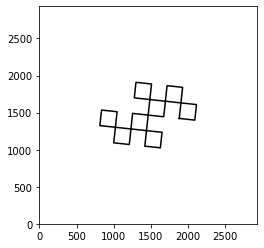

In [13]:
pylab.xlim (0, size)
pylab.ylim (0, size)

x = []
y = []

for i in range(len(eyes_curve) - 1):
    x.append(p1[i][0])
    y.append(p1[i][1])
x.append(p2[-1][0])
y.append(p2[-1][1])

line = matplotlib.lines.Line2D(x, y, color="k")
axes = pylab.gca()
axes.set_aspect("equal")
axes.add_line(line)
pylab.show()

In [14]:
a = []

for i in range(len(p1)):
    target_triangle = np.float32([[p1[i][0], p1[i][1]], [p2[i][0], p2[i][1]], [p3[i][0], p3[i][1]]])
    tr = cv2.getAffineTransform(np.float32([pl, pr, pc]), target_triangle)
    new_img = cv2.warpAffine(img, tr, (size, size))
    a.append(new_img)

In [15]:
def merge(images):
    res = np.zeros_like(images[0], dtype=np.float32)

    weights = np.exp(np.array(wghts).astype(np.float32))
    weights *= np.arange(len(images))[::-1]
    weights /= np.sum(weights)

    for n, i in enumerate(images):
        res += i.astype(np.float32) * weights[n]

    return res.astype(np.ubyte)

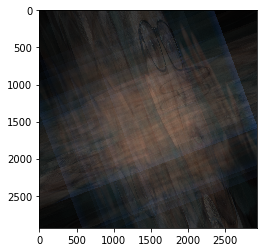

In [16]:
res_im = merge(a)
plt.imshow(res_im)

In [17]:
cv2.imwrite('results/gates_dragon.jpg', cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB))

True